In [2]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model
from keras import backend as K    
K.set_image_dim_ordering('th') 

In [3]:
corpus = pd.read_pickle('../data/MR.pkl')
corpus= corpus.sample(frac=1)
sentences, labels = list(corpus.sentence), list(corpus.label)
print len(sentences)

10662


In [4]:
corpus.head(5)

,label,sentence,split
62,0,the cumulative effect of watching this 65 minu...,train
10190,1,"rarely has skin looked as beautiful , desirabl...",train
5385,1,behind the snow games and lovable siberian hus...,train
6632,1,"the weight of the piece , the unerring profess...",train
6822,1,based on a devilishly witty script by heather ...,train


In [5]:
#Increasing the value will increase sequence length in many sentences. Captures more words
TOP_N_WORDS = 5000

In [6]:
tokenizer = Tokenizer(nb_words=TOP_N_WORDS)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/home/manoj/anaconda2/lib/python2.7/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 18758 unique tokens.


In [8]:
#This will show how the first sentence has been converted to numeric sequence
print sequences[0]
#This will show the first sentence itself
print "Sentence: "+sentences[0]
#This will loop through every word of the first sentence and see which word is not added in the sequence.
print "Comment: Words not added from the first sentence along with their ID`s"
words = sentences[0].split(" ")
for i in words:
    if i in word_index:
        if word_index[i] not in sequences[0]:
            print i, word_index[i]

[1, 4626, 968, 4, 197, 16, 362, 1387, 6, 190, 27, 132, 2000, 95, 61, 882, 4627, 46, 1, 270, 64, 1704, 4, 1, 193, 5, 211, 113, 20, 126, 1484, 15, 1, 3908, 5, 180]
Sentence: the cumulative effect of watching this 65 minute trifle is rather like being trapped while some weird relative trots out the video he took of the family vacation to stonehenge . before long , you 're desperate for the evening to end .
Comment: Words not added from the first sentence along with their ID`s
65 5593
trots 7192
vacation 10106
stonehenge 10107


In [9]:
max_sequence_length = 0
min_sequence_length = -1
j = -1
for i in sequences:
    seq_len = len(i)
    
    if min_sequence_length == -1:
        min_sequence_length = seq_len
        
    if seq_len > max_sequence_length:
        max_sequence_length = seq_len
    
    if seq_len < min_sequence_length and min_sequence_length!=-1:
        min_sequence_length = seq_len
        j = i
        
print min_sequence_length
print max_sequence_length

0
52


In [10]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
import numpy as np
data_labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', data_labels.shape)

('Shape of data tensor:', (10662, 52))
('Shape of label tensor:', (10662, 2))


In [11]:
data[0]
data_labels[0]

array([1., 0.])

In [12]:
import os
GLOVE_DIR = "/home/manoj/Downloads/glove.6B/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print "Loaded "+str(len(embeddings_index))+" word embeddings from GLOVE"

Loaded 400000 word embeddings from GLOVE


In [13]:
EMBEDDING_DIM = len(embeddings_index["the"])

In [14]:
#+1 for bias.
#len(word_index) because we have so many unique tokens after all the filtering.

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be random numbers.
        embedding_matrix[i] = embedding_vector

In [15]:
embedding_matrix.shape

(18759, 100)

In [16]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=True)

In [43]:
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
#x = Conv1D(128, 5, activation='relu')(x)
#x = MaxPooling1D(5)(x)
x = Flatten()(x)
#x = Dense(128, activation='relu')(x)
x = Dense(100, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 52)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 52, 100)           1875900   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 48, 128)           64128     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               115300    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total para

In [45]:
performance = model.fit(data, data_labels,epochs=10, batch_size=128, validation_split=0.1)

Train on 9595 samples, validate on 1067 samples
Epoch 1/10
9595/9595 [==============================] - 8s 803us/step - loss: 0.5429 - acc: 0.7265 - val_loss: 0.5700 - val_acc: 0.7545
Epoch 2/10
9595/9595 [==============================] - 7s 703us/step - loss: 0.2085 - acc: 0.9106 - val_loss: 0.7343 - val_acc: 0.7545
Epoch 3/10
9595/9595 [==============================] - 7s 708us/step - loss: 0.1238 - acc: 0.9495 - val_loss: 0.9023 - val_acc: 0.7488
Epoch 4/10
9595/9595 [==============================] - 7s 709us/step - loss: 0.0737 - acc: 0.9680 - val_loss: 1.1705 - val_acc: 0.7451
Epoch 5/10
9595/9595 [==============================] - 7s 713us/step - loss: 0.0519 - acc: 0.9769 - val_loss: 1.3083 - val_acc: 0.7366
Epoch 6/10
9595/9595 [==============================] - 7s 718us/step - loss: 0.0392 - acc: 0.9802 - val_loss: 1.4590 - val_acc: 0.7432
Epoch 7/10
9595/9595 [==============================] - 7s 722us/step - loss: 0.0334 - acc: 0.9825 - val_loss: 1.5603 - val_acc: 0.7516


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

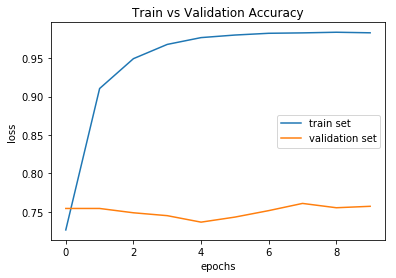

In [47]:
plt.plot(performance.history['acc'])
plt.plot(performance.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train set', 'validation set'], loc='best')
plt.title('Train vs Validation Accuracy')